In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

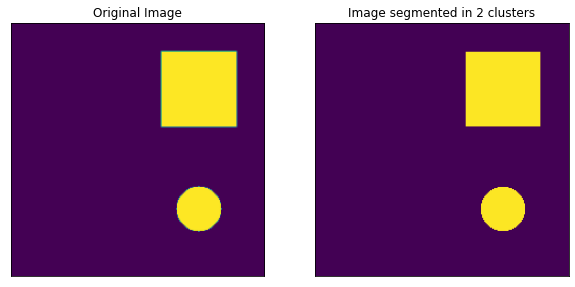

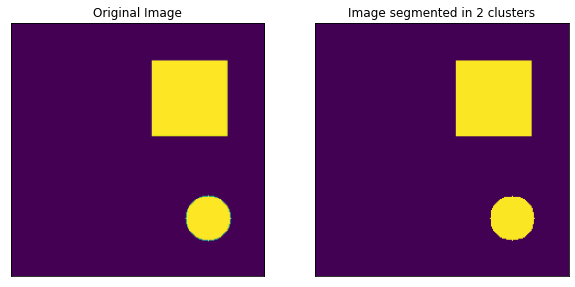

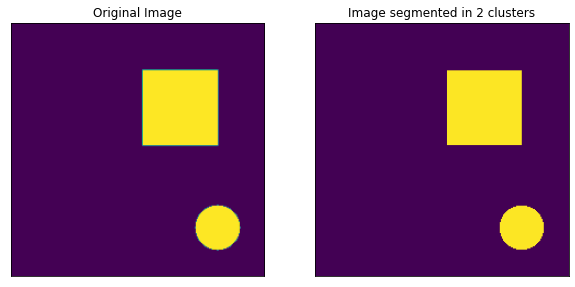

In [2]:
# Image segmentation with K-means
def imageSegmentation(img):
    vectorized = np.float32(img.reshape((-1,3)))
    # Define criteria and execute kmeans()
    noClusters = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(vectorized, noClusters, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    # Convert back to original image
    center = np.uint8(center)
    result_img = center[label.flatten()]
    result_img = result_img.reshape((img.shape))
    return result_img

def show(original, frame):
    # Show two images to compare them
    figure_size = 10
    plt.figure(figsize=(figure_size, figure_size))
    plt.subplot(1,2,1), plt.imshow(original)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2), plt.imshow(frame)
    plt.title('Image segmented in '+ str(2) +' clusters'), plt.xticks([]), plt.yticks([])
    plt.show()
    
# Read image, convert to rgb and segment
original1 = cv2.cvtColor(cv2.imread('../11.1.png'), cv2.COLOR_BGR2RGB)
original2 = cv2.cvtColor(cv2.imread('../11.2.png'), cv2.COLOR_BGR2RGB)
original3 = cv2.cvtColor(cv2.imread('../11.3.png'), cv2.COLOR_BGR2RGB)
frame1 = imageSegmentation(original1)
frame2 = imageSegmentation(original2)
frame3 = imageSegmentation(original3)

# Show images
show(original1, frame1)
show(original2, frame2)
show(original3, frame3)

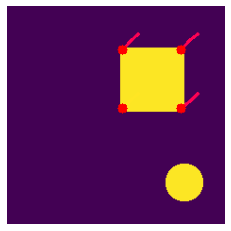

In [4]:
# LUCAS-KANADE OPTICAL FLOW

# Read images, segment with the previous method and create also their grayscale version
original1 = cv2.cvtColor(cv2.imread('../11.1.png'), cv2.COLOR_BGR2RGB)
original2 = cv2.cvtColor(cv2.imread('../11.2.png'), cv2.COLOR_BGR2RGB)
original3 = cv2.cvtColor(cv2.imread('../11.3.png'), cv2.COLOR_BGR2RGB)
frame1 = imageSegmentation(original1)
frame2 = imageSegmentation(original2)
frame3 = imageSegmentation(original3)
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
frame3_gray = cv2.cvtColor(frame3, cv2.COLOR_RGB2GRAY)

# Parameters for ShiTomasi corner detection and Lucas-Kanade optical flow
corDet_params = dict(maxCorners = 100, qualityLevel = 0.3, minDistance = 7, blockSize = 7)
OpFl_params = dict(winSize  = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Find corner in first frame
p0 = cv2.goodFeaturesToTrack(frame1_gray, mask = None, **corDet_params)
# Mask to draw
mask = np.zeros_like(frame1)

# FRAME 1 -> 2
# Compute Lucas-Kanade optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, p0, None, **OpFl_params)
# Select points to draw
points_new = p1[st==1]
points_old = p0[st==1]
# Draw in the mask
for _, (newP, oldP) in enumerate(zip(points_new, points_old)):
    a, b = newP.ravel()
    c, d = oldP.ravel()
    mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), [255, 0, 0], 2)
    frame = cv2.circle(frame2, (int(a), int(b)), 5, [255, 0, 0], -1)
res = cv2.add(mask, frame)
# Update previous frame and previous points
p0 = points_new.reshape(-1,1,2)

# FRAME 2 -> 3; same procedure as before
p1, st, err = cv2.calcOpticalFlowPyrLK(frame2_gray, frame3_gray, p0, None, **OpFl_params)
points_new = p1[st==1]
points_old = p0[st==1]
for _, (newP, oldP) in enumerate(zip(points_new, points_old)):
    a,b = newP.ravel()
    c,d = oldP.ravel()
    mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), [255, 0, 0], 2)
    frame = cv2.circle(frame3, (int(a), int(b)), 5, [255, 0, 0],-1)
res = cv2.add(mask, frame)
p0 = points_new.reshape(-1,1,2)

# Save and show
plt.axis("off")
plt.imshow(res)
res = cv2.imwrite('11.optical.jpg', cv2.cvtColor(res, cv2.COLOR_RGB2BGR))

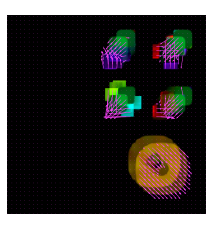

In [6]:
# GUNNAR-FARNEBACK OPTICAL FLOW

# Read images, segment with the previous method and create also their grayscale version
original1 = cv2.cvtColor(cv2.imread('../11.1.png'), cv2.COLOR_BGR2RGB)
original2 = cv2.cvtColor(cv2.imread('../11.2.png'), cv2.COLOR_BGR2RGB)
original3 = cv2.cvtColor(cv2.imread('../11.3.png'), cv2.COLOR_BGR2RGB)
frame1 = imageSegmentation(original1)
frame2 = imageSegmentation(original2)
frame3 = imageSegmentation(original3)
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
frame3_gray = cv2.cvtColor(frame3, cv2.COLOR_RGB2GRAY)

# FRAME 1 -> 2
# A hsv image is created and, at the end, converted back to rgb 
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
# Compute Gunnar-Farneback optical flow
flow1 = cv2.calcOpticalFlowFarneback(frame1_gray, frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
magnitude, angle = cv2.cartToPolar(flow1[...,0], flow1[...,1])
hsv[...,0] = angle*180/np.pi/2
hsv[...,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
result1 = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# FRAME 2 -> 3; same procedure as before+arrows drawing
hsv = np.zeros_like(frame2)
hsv[...,1] = 255
flow2 = cv2.calcOpticalFlowFarneback(frame2_gray, frame3_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

## Plot arrows: unluckly in this way we only plot them for frame2-3 shifting (but it is still okay for this case)
fig2, ax = plt.subplots()
ax.axis("off")
height, width, *_ = flow2.shape
x = np.linspace(0, width-1, int(width/5), dtype=np.int64)
y = np.linspace(0, height-1, int(height/5), dtype=np.int64)
flow = flow2[np.ix_(y, x)]
ax.quiver(x, y, flow[:, :, 0], flow[:, :, 1], angles="xy", scale_units="xy", scale = 1, color="#ff44ff")
ax.set_ylim(sorted(ax.get_ylim(), reverse=True))
ax.set_aspect("equal")

magnitude, angle = cv2.cartToPolar(flow2[...,0], flow2[...,1])
hsv[...,0] = angle*180/np.pi/2
hsv[...,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
result2 = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
cv2.imwrite('11.optical_1-2.png', cv2.cvtColor(result1, cv2.COLOR_RGB2BGR))
cv2.imwrite('11.optical_2-3.png', cv2.cvtColor(result2, cv2.COLOR_RGB2BGR))

# Merge frame1-2 and frame2-3 results
final_result = cv2.add(result1, result2)
# Save and show
cv2.imwrite('11.optical_result.png', cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR))
plt.imshow(final_result)

Reference: OpenCV Documentation